In [4]:
# save the trained model
#PATH = './mymodel.pth'
#torch.save(clf.state_dict(), PATH)

In [5]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import json
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:

# Lee el archivo CSV
data = pd.read_csv('roberta_embeddings.csv')

# Visualiza las primeras filas del dataframe
# Dividir los datos en características (X) y etiquetas (y)
X = data.drop('cat_one_hot', axis=1)  # Eliminar la columna 'cat_one_hot' para obtener las características
etiquetas = []
y = data['cat_one_hot'].tolist()
for lista in y:
    #print(type(lista))
    vector = eval(lista)
    indice_maximo = vector.index(max(vector))
    etiquetas.append(indice_maximo)

labels = pd.DataFrame()
labels['label'] = etiquetas
print(labels)

      label
0         0
1         0
2         0
3         0
4         0
...     ...
7745      4
7746      4
7747      4
7748      4
7749      4

[7750 rows x 1 columns]


In [10]:
import time
# Definir la arquitectura de la red neuronal
class SimpleClassifier(nn.Module):
    def __init__(self,input_size,output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256,128)
        self.fc5 = nn.Linear(128,64)
        self.fc6 = nn.Linear(64, 5)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.5)  # Por ejemplo, con una probabilidad de dropout del 50%

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        x = self.softmax(x)
        return x.to(device)

def crear_directorio(nombre_carpeta):
    directorio_actual = os.getcwd()
    print("El directorio actual es:", directorio_actual)
    ruta_nueva_carpeta = os.path.join(directorio_actual, nombre_carpeta)
    # Verificar si la carpeta ya existe
    if not os.path.exists(ruta_nueva_carpeta):
        # Crear la carpeta si no existe
        os.mkdir(ruta_nueva_carpeta)
        print("Se creó la carpeta", nombre_carpeta, "en", directorio_actual)
    else:
        print("La carpeta", nombre_carpeta, "ya existe en", directorio_actual)

    ruta_modificada = ruta_nueva_carpeta.replace("\\","/")
    return ruta_modificada

def RNN_model(X,labels,test_size,epochs,lr):
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)
    X_train_values = X_train.values
    X_train_tensor = torch.tensor(X_train_values,dtype=torch.float32)
    y_train_values = y_train.values
    y_train_tensor = torch.tensor(y_train_values,dtype=torch.long)
    X_test_values = X_test.values
    X_test_tensor = torch.tensor(X_test_values,dtype=torch.float32)
    y_test_values = y_test.values
    y_test_tensor = torch.tensor(y_test_values,dtype=torch.long)
    y_train_tensor_flat = torch.tensor(y_train.values.flatten(), dtype=torch.long)
    output_size = 5
    # Crear un DataLoader para manejar los datos de entrenamiento
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor_flat)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    input_size = X_train_values[0].shape[0]
    
    # Instanciar el modelo y definir la función de pérdida y el optimizador
    model = SimpleClassifier(input_size,output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Entrenar el modelo
    losses = []
    sum_losses = 1
    #while sum_losses > error:
    for epoch in tqdm(range(epochs),desc="Procesando epocas: "):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Mover datos al dispositivo
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            #print(f"Valor de error:  {loss}")
            optimizer.step()
            running_loss += loss.item()
        sum_losses = running_loss / len(train_loader)
        #print(sum_losses)
        losses.append(sum_losses)
    
    # Graficar el loss durante el entrenamiento
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    ruta_figura_incom = crear_directorio("Neural_network_classification")

    nombre_carpeta = f"RRN_{epochs}_{lr}_{test_size}"
    os.makedirs(os.path.join(ruta_figura_incom, nombre_carpeta), exist_ok=True)
    ruta_figura_incom = ruta_figura_incom + "/" + nombre_carpeta
    
    ruta_figura = f"{ruta_figura_incom}/funcion_de_perdida_{epochs}_{lr}.png"
    plt.savefig(ruta_figura)
    print("Matriz de confusión guardada en:", ruta_figura)
    plt.show()
    plt.show()
    
    # Evaluar el modelo en el conjunto de prueba
    with torch.no_grad():
        X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
        print('Test accuracy:', accuracy)
    
    predicted = predicted.cpu()  # Moviendo las predicciones a la CPU
    
    
    # Calcula las métricas
    accuracy = accuracy_score(y_test_tensor.cpu(), predicted.numpy())
    precision = precision_score(y_test, predicted.numpy(), average='macro', zero_division=0)
    recall = recall_score(y_test, predicted.numpy(), average='macro', zero_division=0)
    f1 = f1_score(y_test, predicted.numpy(), average='macro', zero_division=0)

    diccionario = {'accuracy':accuracy,'precision':precision,'recall':recall,'f1':f1}

    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1)
    print("\n")
    # Calcular métricas
    print('Classification Report:')
    print(classification_report(y_test, predicted.numpy()))
    reporte_clasificacion = classification_report(y_test, predicted.numpy(),output_dict = True)
    report_df = pd.DataFrame(reporte_clasificacion)
    print(report_df)
    # Calcular matriz de confusión
    conf_matrix = confusion_matrix(y_test, predicted.numpy())
    
    # Crear un mapa de calor para la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title('Matriz de Confusión')
    plt.xlabel('Etiquetas Predichas')
    plt.ylabel('Etiquetas Verdaderas')
    
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    ruta_figura_incom = crear_directorio("Neural_network_classification")
    
    nombre_carpeta = f"RRN_{epochs}_{lr}_{test_size}"
    os.makedirs(os.path.join(ruta_figura_incom, nombre_carpeta), exist_ok=True)
    ruta_figura_incom = ruta_figura_incom + "/" + nombre_carpeta
    
    ruta_figura = f"{ruta_figura_incom}/matriz_confusion_{epochs}_{lr}.png"
    plt.savefig(ruta_figura)
    print("Matriz de confusión guardada en:", ruta_figura)
    plt.show()

    res = f"/resultados_{epochs}_{lr}_{test_size}.json"
    res1 = f"/reporte_clasificacion_{epochs}_{lr}_{test_size}.csv"
    ruta_archivo_json = ruta_figura_incom + res
    ruta_archivo_json_report = ruta_figura_incom + res1

    # Guardar el diccionario como un archivo JSON
    with open(ruta_archivo_json, "w") as archivo_json:
        json.dump(diccionario, archivo_json)

    report_df.to_csv(ruta_archivo_json_report)
    
    print("Diccionario guardado como JSON en:", ruta_archivo_json)
    

In [11]:
print(labels)

      label
0         0
1         0
2         0
3         0
4         0
...     ...
7745      4
7746      4
7747      4
7748      4
7749      4

[7750 rows x 1 columns]


Procesando red con 500 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 500/500 [06:38<00:00,  1.26it/s]

El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_500_0.0001_0.3/funcion_de_perdida_500_0.0001.png


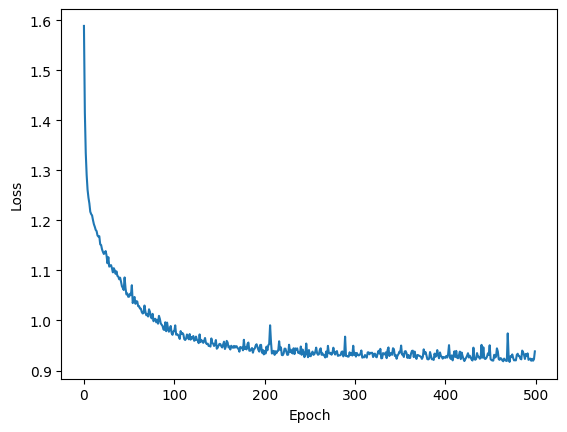

Test accuracy: 465.37548387096774
Accuracy: 0.896774193548387
Precision: 0.896642134991388
Recall: 0.8946379902882086
F1-score: 0.8950566954729531


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       495
           1       0.99      0.91      0.95       472
           2       0.75      0.76      0.76       449
           3       0.86      0.92      0.89       463
           4       0.88      0.90      0.89       446

    accuracy                           0.90      2325
   macro avg       0.90      0.89      0.90      2325
weighted avg       0.90      0.90      0.90      2325

                    0           1           2           3           4  \
precision    0.995927    0.993056    0.752759    0.862348    0.879121   
recall       0.987879    0.908898    0.759465    0.920086    0.896861   
f1-score     0.991886    0.949115    0.756098    0.890282    0.887902   
support    495.000000  472.000000  449.000000  

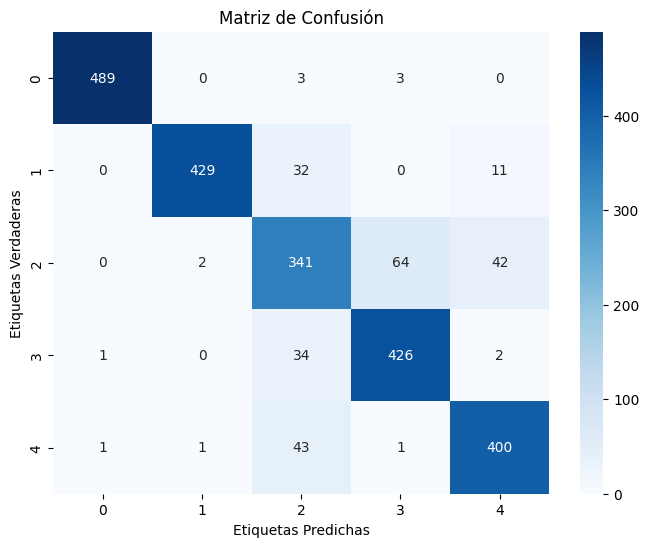

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_500_0.0001_0.3/resultados_500_0.0001_0.3.json
Procesando red con 500 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 500/500 [08:33<00:00,  1.03s/it]

El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_500_1e-05_0.3/funcion_de_perdida_500_1e-05.png


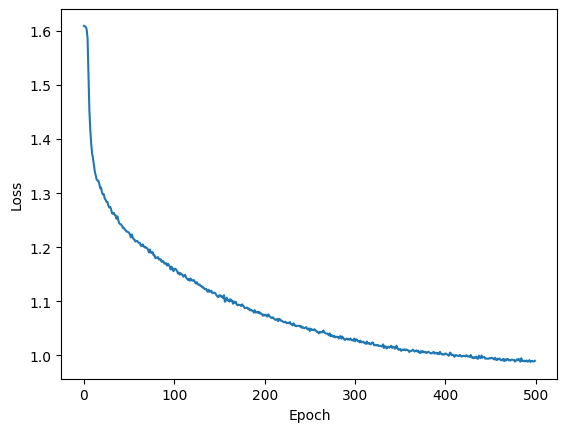

Test accuracy: 465.6830107526882
Accuracy: 0.8120430107526881
Precision: 0.8074949126309093
Recall: 0.8076761549502234
F1-score: 0.8058541594664635


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       495
           1       0.94      0.89      0.92       472
           2       0.66      0.56      0.61       449
           3       0.77      0.84      0.80       463
           4       0.70      0.77      0.73       446

    accuracy                           0.81      2325
   macro avg       0.81      0.81      0.81      2325
weighted avg       0.81      0.81      0.81      2325

                    0           1           2           3           4  \
precision    0.969819    0.939866    0.664021    0.766798    0.696970   
recall       0.973737    0.894068    0.559020    0.838013    0.773543   
f1-score     0.971774    0.916395    0.607013    0.800826    0.733262   
support    495.000000  472.000000  449.000000 

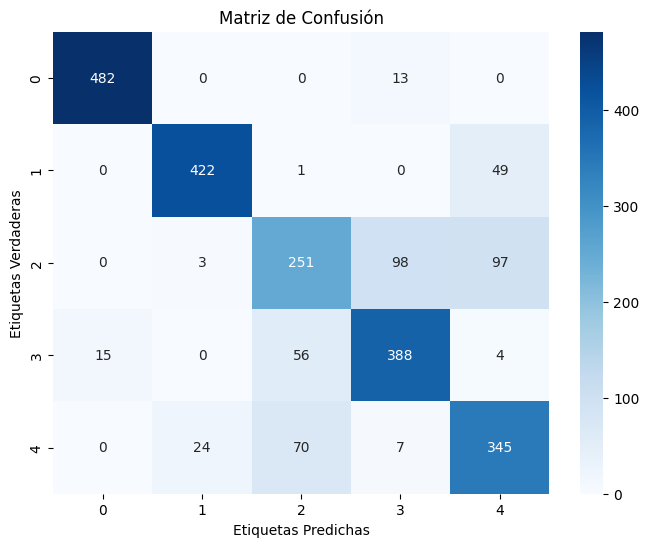

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_500_1e-05_0.3/resultados_500_1e-05_0.3.json
Procesando red con 700 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 700/700 [14:41<00:00,  1.26s/it]

El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_700_0.0001_0.3/funcion_de_perdida_700_0.0001.png


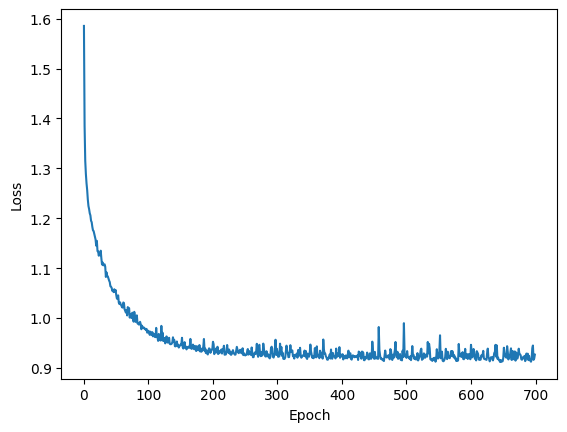

Test accuracy: 465.22494623655916
Accuracy: 0.9131182795698924
Precision: 0.9151332746349279
Recall: 0.9113973402696647
F1-score: 0.9122954721663353


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       495
           1       0.99      0.94      0.97       472
           2       0.77      0.85      0.81       449
           3       0.95      0.87      0.91       463
           4       0.87      0.90      0.89       446

    accuracy                           0.91      2325
   macro avg       0.92      0.91      0.91      2325
weighted avg       0.92      0.91      0.91      2325

                    0           1           2           3           4  \
precision    0.991952    0.988889    0.768145    0.952494    0.874187   
recall       0.995960    0.942797    0.848552    0.866091    0.903587   
f1-score     0.993952    0.965293    0.806349    0.907240    0.888644   
support    495.000000  472.000000  449.000000

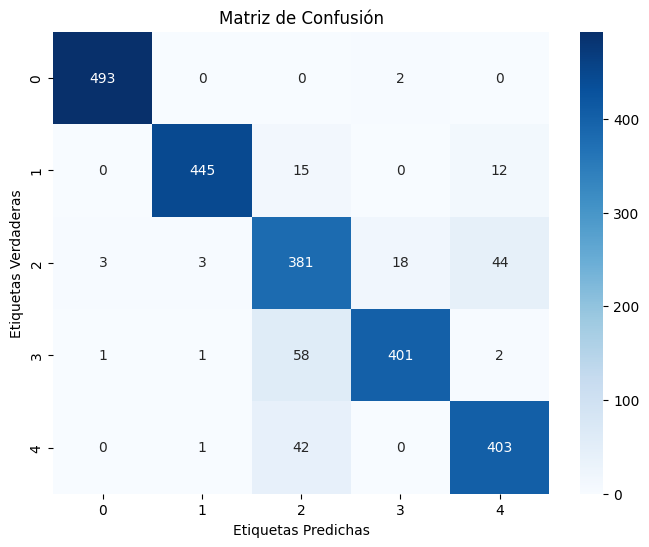

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_700_0.0001_0.3/resultados_700_0.0001_0.3.json
Procesando red con 700 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 700/700 [14:44<00:00,  1.26s/it]

El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_700_1e-05_0.3/funcion_de_perdida_700_1e-05.png


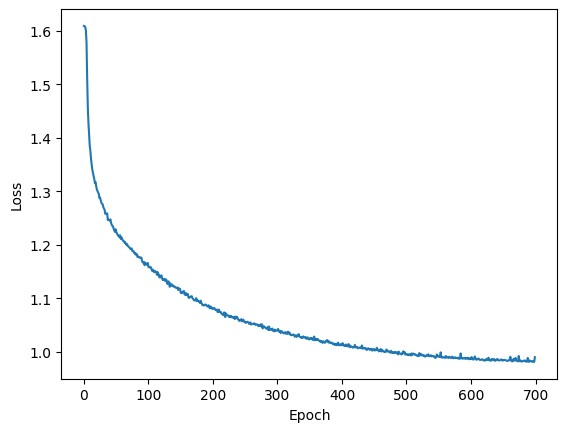

Test accuracy: 465.3737634408602
Accuracy: 0.8180645161290323
Precision: 0.8151556908842892
Recall: 0.8141573867621277
F1-score: 0.8131439599304897


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       495
           1       0.95      0.90      0.92       472
           2       0.66      0.58      0.62       449
           3       0.79      0.83      0.81       463
           4       0.70      0.80      0.75       446

    accuracy                           0.82      2325
   macro avg       0.82      0.81      0.81      2325
weighted avg       0.82      0.82      0.82      2325

                    0           1           2           3           4  \
precision    0.975460    0.948661    0.664962    0.788066    0.698630   
recall       0.963636    0.900424    0.579065    0.827214    0.800448   
f1-score     0.969512    0.923913    0.619048    0.807165    0.746082   
support    495.000000  472.000000  449.000000 

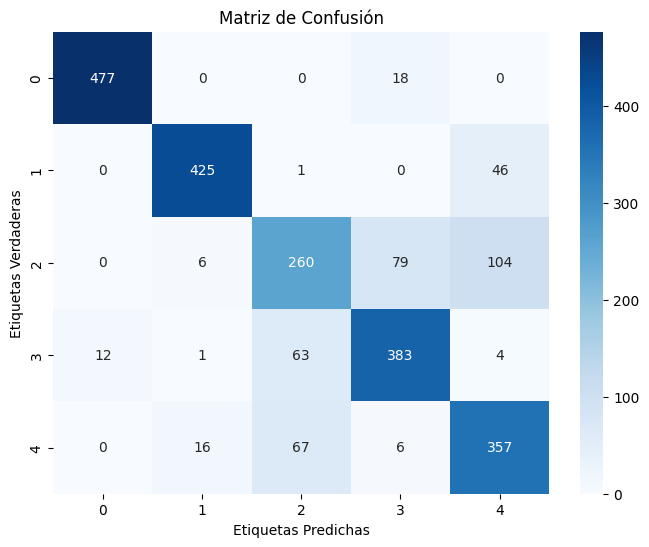

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_700_1e-05_0.3/resultados_700_1e-05_0.3.json
Procesando red con 1000 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas: 100%|███████████████████████████████████████████████████████████| 1000/1000 [21:06<00:00,  1.27s/it]

El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_1000_0.0001_0.3/funcion_de_perdida_1000_0.0001.png


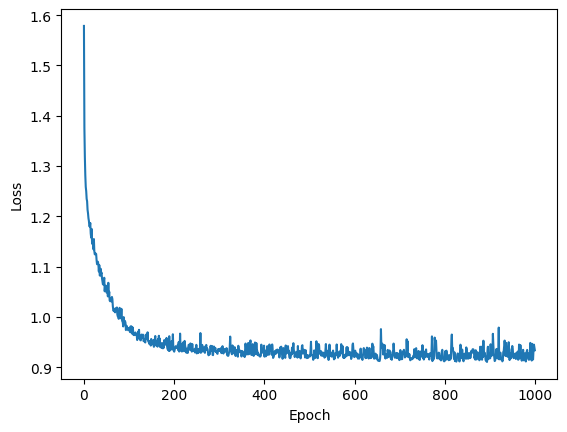

Test accuracy: 465.8043010752688
Accuracy: 0.9096774193548387
Precision: 0.9089021429289378
Recall: 0.9072405965205566
F1-score: 0.907329179394328


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       495
           1       0.99      0.96      0.97       472
           2       0.79      0.78      0.79       449
           3       0.86      0.96      0.91       463
           4       0.91      0.86      0.88       446

    accuracy                           0.91      2325
   macro avg       0.91      0.91      0.91      2325
weighted avg       0.91      0.91      0.91      2325

                    0           1           2           3           4  \
precision    0.993902    0.989035    0.791855    0.860194    0.909524   
recall       0.987879    0.955508    0.779510    0.956803    0.856502   
f1-score     0.990881    0.971983    0.785634    0.905930    0.882217   
support    495.000000  472.000000  449.000000  

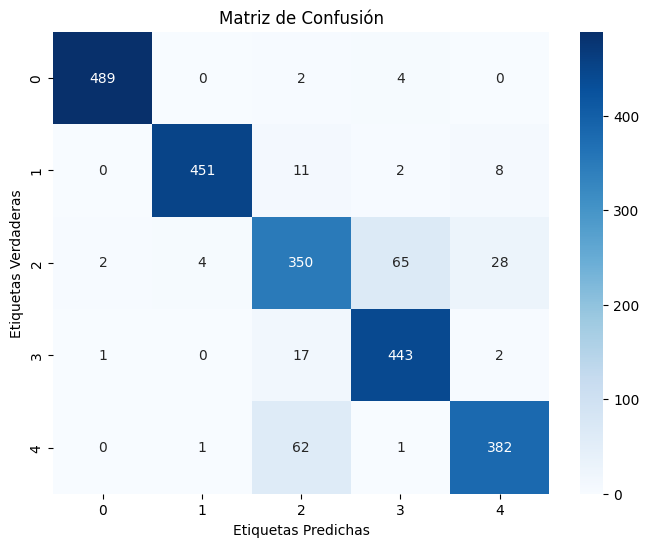

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_1000_0.0001_0.3/resultados_1000_0.0001_0.3.json
Procesando red con 1000 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas: 100%|███████████████████████████████████████████████████████████| 1000/1000 [21:14<00:00,  1.27s/it]

El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_1000_1e-05_0.3/funcion_de_perdida_1000_1e-05.png


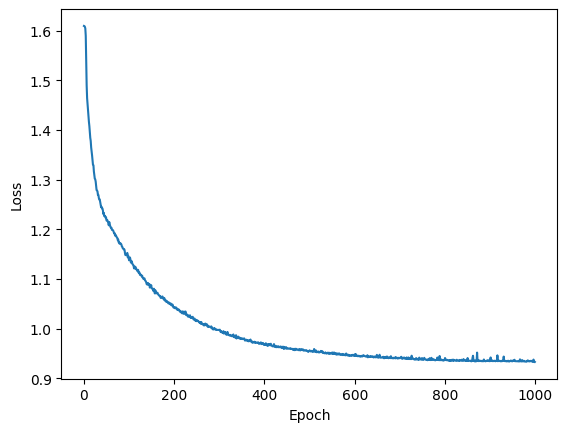

Test accuracy: 465.6851612903226
Accuracy: 0.890752688172043
Precision: 0.8883469680094691
Recall: 0.8882515974589357
F1-score: 0.8882963487954652


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       495
           1       0.96      0.96      0.96       472
           2       0.75      0.75      0.75       449
           3       0.87      0.87      0.87       463
           4       0.88      0.88      0.88       446

    accuracy                           0.89      2325
   macro avg       0.89      0.89      0.89      2325
weighted avg       0.89      0.89      0.89      2325

                    0           1           2          3           4  \
precision    0.981891    0.961620    0.748889    0.87041    0.878924   
recall       0.985859    0.955508    0.750557    0.87041    0.878924   
f1-score     0.983871    0.958555    0.749722    0.87041    0.878924   
support    495.000000  472.000000  449.000000  463.

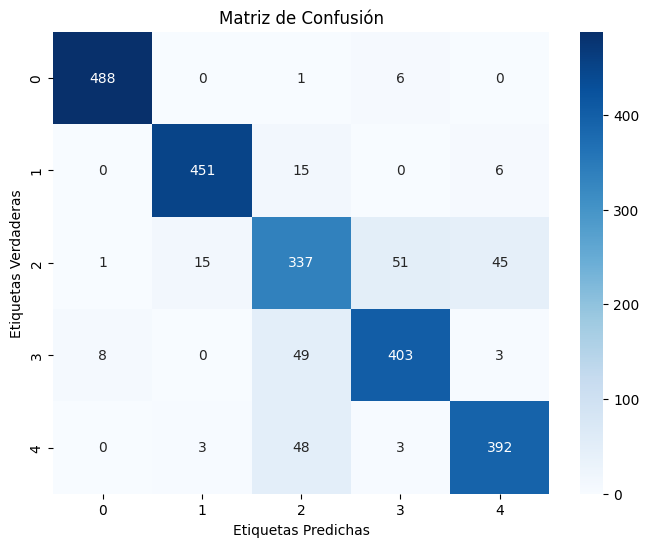

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_1000_1e-05_0.3/resultados_1000_1e-05_0.3.json
Procesando red con 500 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 500/500 [10:31<00:00,  1.26s/it]

El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_500_0.0001_0.2/funcion_de_perdida_500_0.0001.png


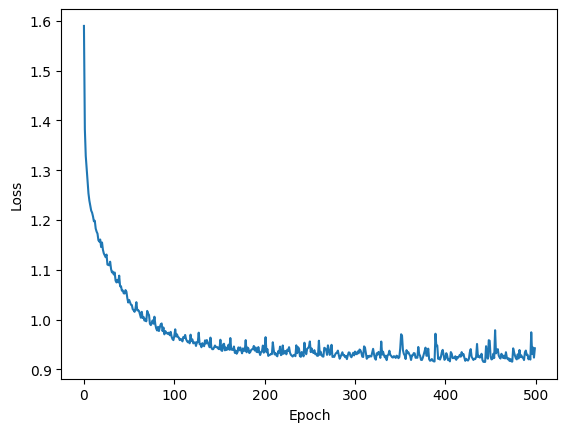

Test accuracy: 466.3169892473118
Accuracy: 0.8881720430107527
Precision: 0.8892854656076652
Recall: 0.8846415956263677
F1-score: 0.8843401180438383


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       495
           1       0.99      0.96      0.97       472
           2       0.74      0.71      0.72       449
           3       0.81      0.97      0.88       463
           4       0.93      0.80      0.86       446

    accuracy                           0.89      2325
   macro avg       0.89      0.88      0.88      2325
weighted avg       0.89      0.89      0.89      2325

                    0           1           2           3           4  \
precision    0.980119    0.986871    0.737209    0.810469    0.931759   
recall       0.995960    0.955508    0.706013    0.969762    0.795964   
f1-score     0.987976    0.970936    0.721274    0.882989    0.858525   
support    495.000000  472.000000  449.000000 

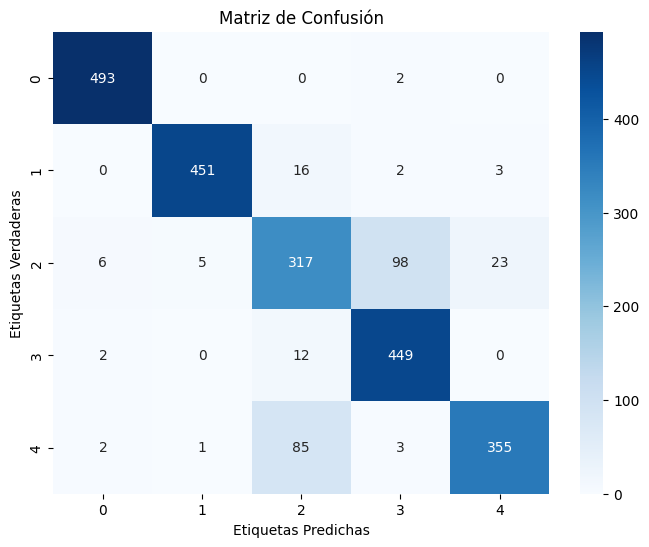

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_500_0.0001_0.2/resultados_500_0.0001_0.2.json
Procesando red con 500 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 500/500 [10:23<00:00,  1.25s/it]

El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_500_1e-05_0.2/funcion_de_perdida_500_1e-05.png


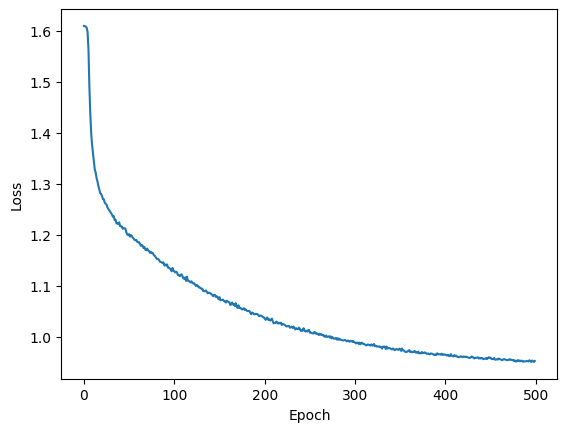

Test accuracy: 465.88774193548386
Accuracy: 0.8701075268817204
Precision: 0.8672724271620718
Recall: 0.8668245820933942
F1-score: 0.8668954625817158


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       495
           1       0.95      0.94      0.95       472
           2       0.70      0.70      0.70       449
           3       0.84      0.87      0.86       463
           4       0.87      0.83      0.85       446

    accuracy                           0.87      2325
   macro avg       0.87      0.87      0.87      2325
weighted avg       0.87      0.87      0.87      2325

                    0           1           2           3           4  \
precision    0.980000    0.946921    0.702222    0.841336    0.865882   
recall       0.989899    0.944915    0.703786    0.870410    0.825112   
f1-score     0.984925    0.945917    0.703003    0.855626    0.845006   
support    495.000000  472.000000  449.000000

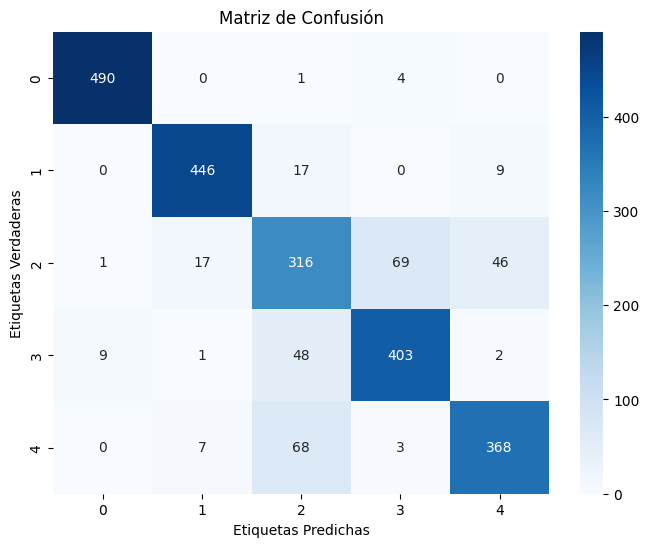

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_500_1e-05_0.2/resultados_500_1e-05_0.2.json
Procesando red con 700 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 700/700 [14:36<00:00,  1.25s/it]

El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_700_0.0001_0.2/funcion_de_perdida_700_0.0001.png


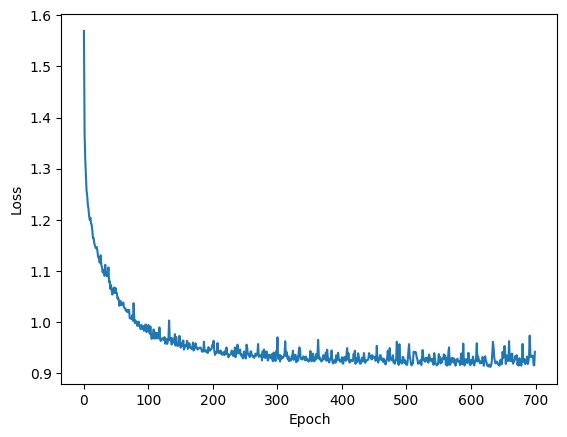

Test accuracy: 465.43612903225807
Accuracy: 0.9161290322580645
Precision: 0.9196609485573128
Recall: 0.9142019539447537
F1-score: 0.9154457729964885


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       495
           1       0.98      0.98      0.98       472
           2       0.75      0.87      0.81       449
           3       0.94      0.86      0.90       463
           4       0.93      0.87      0.90       446

    accuracy                           0.92      2325
   macro avg       0.92      0.91      0.92      2325
weighted avg       0.92      0.92      0.92      2325

                    0           1           2           3           4  \
precision    0.995951    0.978769    0.752399    0.943128    0.928058   
recall       0.993939    0.976695    0.873051    0.859611    0.867713   
f1-score     0.994944    0.977731    0.808247    0.899435    0.896871   
support    495.000000  472.000000  449.000000

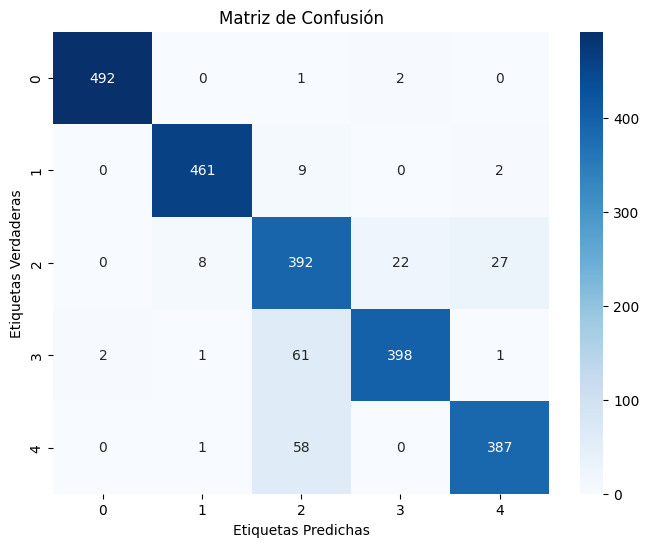

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_700_0.0001_0.2/resultados_700_0.0001_0.2.json
Procesando red con 700 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 700/700 [14:37<00:00,  1.25s/it]

El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_700_1e-05_0.2/funcion_de_perdida_700_1e-05.png


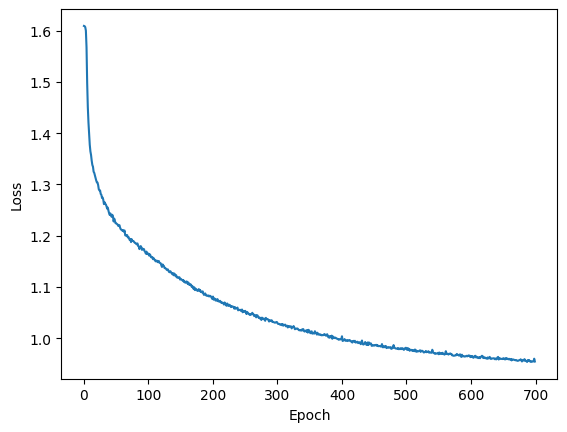

Test accuracy: 465.8025806451613
Accuracy: 0.847741935483871
Precision: 0.8426700808557014
Recall: 0.8441351218009843
F1-score: 0.8431976544967892


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       495
           1       0.95      0.94      0.94       472
           2       0.69      0.64      0.66       449
           3       0.81      0.83      0.82       463
           4       0.80      0.83      0.81       446

    accuracy                           0.85      2325
   macro avg       0.84      0.84      0.84      2325
weighted avg       0.85      0.85      0.85      2325

                    0           1           2           3           4  \
precision    0.972000    0.946809    0.686461    0.805907    0.802174   
recall       0.981818    0.942797    0.643653    0.825054    0.827354   
f1-score     0.976884    0.944798    0.664368    0.815368    0.814570   
support    495.000000  472.000000  449.000000  

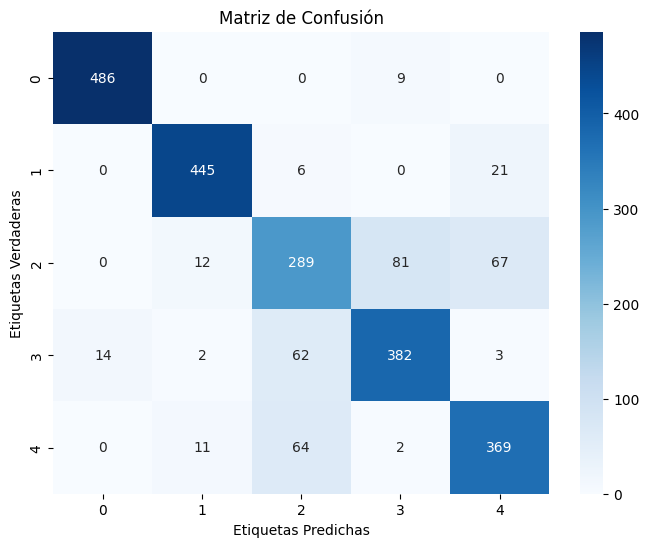

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_700_1e-05_0.2/resultados_700_1e-05_0.2.json
Procesando red con 1000 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas: 100%|███████████████████████████████████████████████████████████| 1000/1000 [21:01<00:00,  1.26s/it]

El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_1000_0.0001_0.2/funcion_de_perdida_1000_0.0001.png


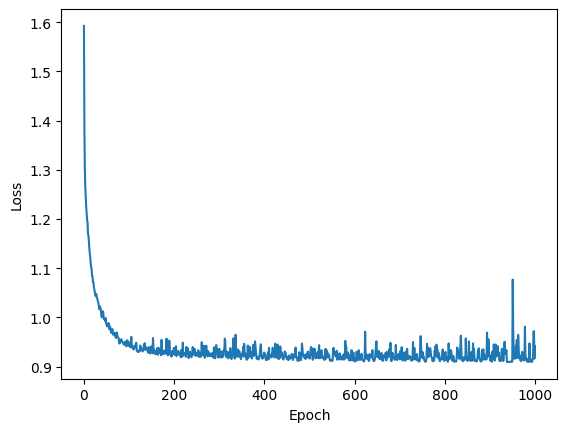

Test accuracy: 465.2064516129032
Accuracy: 0.9156989247311828
Precision: 0.9177695862501857
Recall: 0.914183872657832
F1-score: 0.915285750194452


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       495
           1       1.00      0.93      0.96       472
           2       0.77      0.86      0.81       449
           3       0.92      0.91      0.91       463
           4       0.91      0.89      0.90       446

    accuracy                           0.92      2325
   macro avg       0.92      0.91      0.92      2325
weighted avg       0.92      0.92      0.92      2325

                    0           1           2           3           4  \
precision    0.997947    0.995475    0.769539    0.917211    0.908676   
recall       0.981818    0.932203    0.855234    0.909287    0.892377   
f1-score     0.989817    0.962801    0.810127    0.913232    0.900452   
support    495.000000  472.000000  449.000000  4

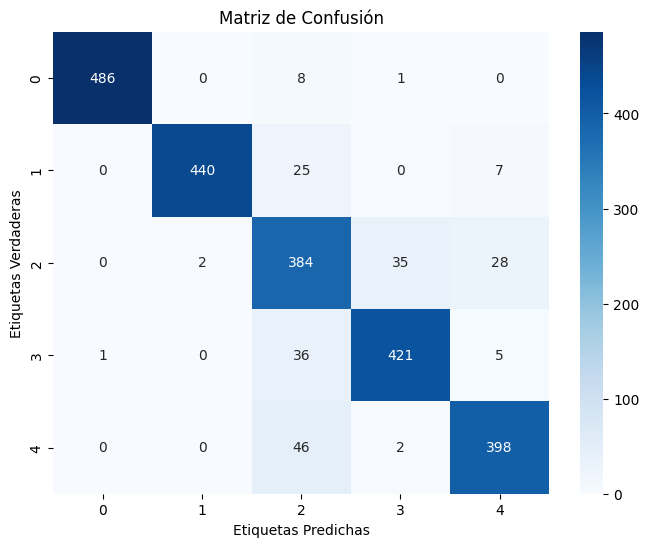

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_1000_0.0001_0.2/resultados_1000_0.0001_0.2.json
Procesando red con 1000 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas: 100%|███████████████████████████████████████████████████████████| 1000/1000 [20:55<00:00,  1.26s/it]

El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_1000_1e-05_0.2/funcion_de_perdida_1000_1e-05.png


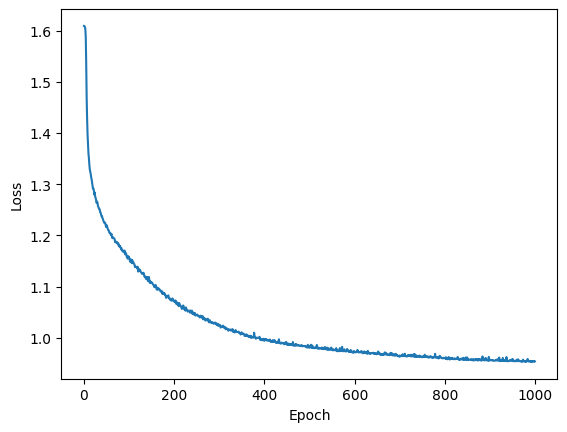

Test accuracy: 465.4868817204301
Accuracy: 0.8412903225806452
Precision: 0.8381630432596682
Recall: 0.8378951100278862
F1-score: 0.8372854780701935


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       495
           1       0.95      0.93      0.94       472
           2       0.70      0.65      0.67       449
           3       0.83      0.80      0.82       463
           4       0.75      0.83      0.79       446

    accuracy                           0.84      2325
   macro avg       0.84      0.84      0.84      2325
weighted avg       0.84      0.84      0.84      2325

                    0           1           2           3           4  \
precision    0.966000    0.952070    0.696897    0.830357    0.745491   
recall       0.975758    0.925847    0.650334    0.803456    0.834081   
f1-score     0.970854    0.938776    0.672811    0.816685    0.787302   
support    495.000000  472.000000  449.000000 

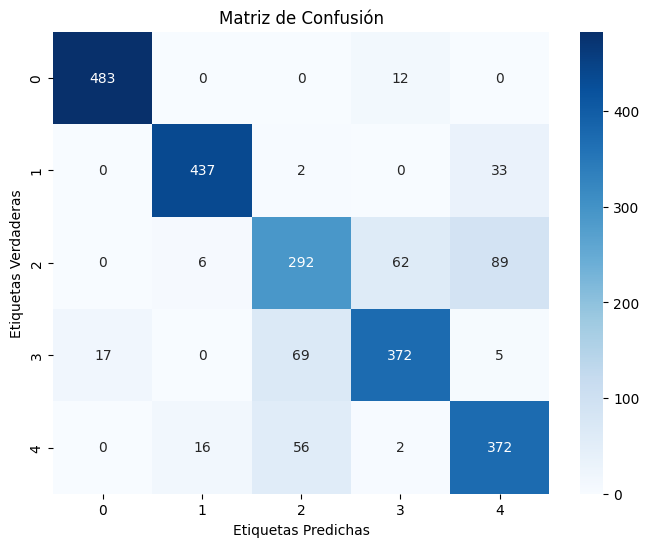

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_1000_1e-05_0.2/resultados_1000_1e-05_0.2.json
Procesando red con 500 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.9


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 500/500 [10:29<00:00,  1.26s/it]

El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_500_0.0001_0.1/funcion_de_perdida_500_0.0001.png


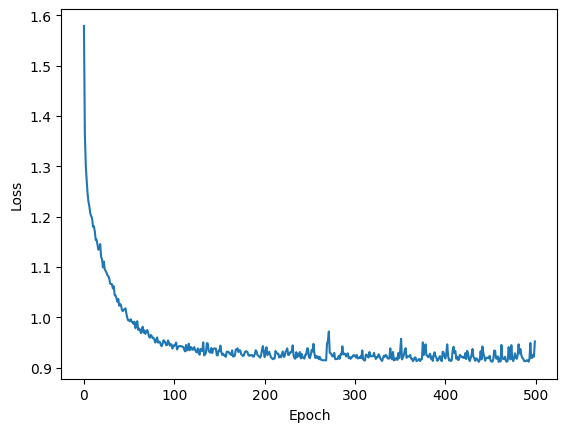

Test accuracy: 466.2236559139785
Accuracy: 0.8851612903225806
Precision: 0.8882759314869831
Recall: 0.8818351140357243
F1-score: 0.8788577898272356


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       495
           1       0.98      0.96      0.97       472
           2       0.83      0.61      0.70       449
           3       0.76      0.97      0.85       463
           4       0.87      0.88      0.88       446

    accuracy                           0.89      2325
   macro avg       0.89      0.88      0.88      2325
weighted avg       0.89      0.89      0.88      2325

                    0           1           2           3           4  \
precision    0.997947    0.980562    0.832827    0.756711    0.873333   
recall       0.981818    0.961864    0.610245    0.974082    0.881166   
f1-score     0.989817    0.971123    0.704370    0.851747    0.877232   
support    495.000000  472.000000  449.000000 

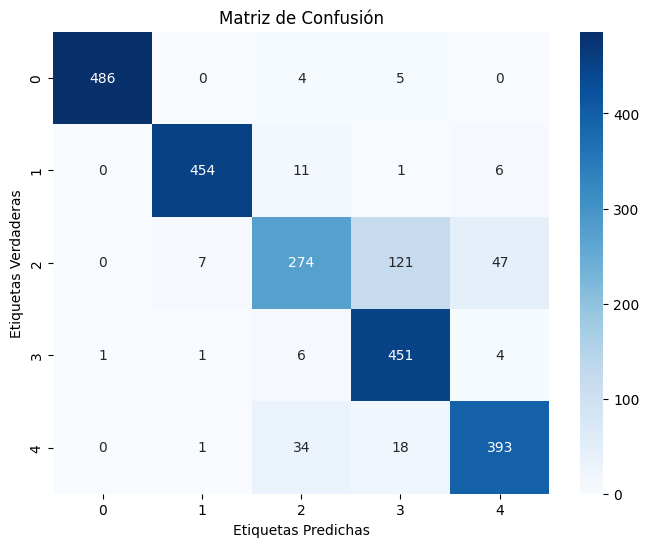

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_500_0.0001_0.1/resultados_500_0.0001_0.1.json
Procesando red con 500 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.9


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 500/500 [10:24<00:00,  1.25s/it]

El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_500_1e-05_0.1/funcion_de_perdida_500_1e-05.png


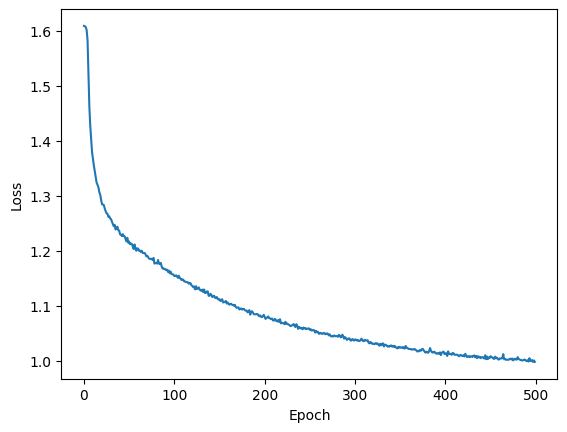

Test accuracy: 465.4464516129032
Accuracy: 0.7978494623655914
Precision: 0.7935787060725685
Recall: 0.7935686864176605
F1-score: 0.7926318319337766


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       495
           1       0.94      0.90      0.92       472
           2       0.61      0.55      0.58       449
           3       0.76      0.76      0.76       463
           4       0.70      0.79      0.74       446

    accuracy                           0.80      2325
   macro avg       0.79      0.79      0.79      2325
weighted avg       0.80      0.80      0.80      2325

                    0           1           2           3           4  \
precision    0.963783    0.940000    0.611794    0.755889    0.696429   
recall       0.967677    0.896186    0.554566    0.762419    0.786996   
f1-score     0.965726    0.917570    0.581776    0.759140    0.738947   
support    495.000000  472.000000  449.000000 

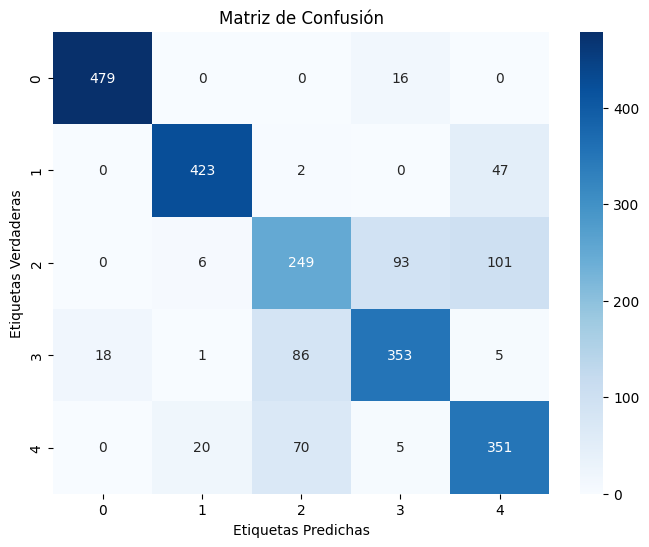

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_500_1e-05_0.1/resultados_500_1e-05_0.1.json
Procesando red con 700 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.9


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 700/700 [14:36<00:00,  1.25s/it]

El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_700_0.0001_0.1/funcion_de_perdida_700_0.0001.png


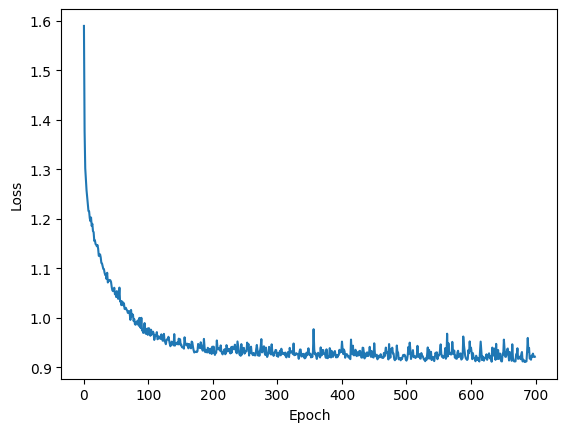

Test accuracy: 465.66709677419357
Accuracy: 0.9195698924731183
Precision: 0.9170560812180863
Recall: 0.9174848847242212
F1-score: 0.916714893421493


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       495
           1       0.98      0.97      0.98       472
           2       0.83      0.76      0.80       449
           3       0.89      0.95      0.92       463
           4       0.88      0.92      0.90       446

    accuracy                           0.92      2325
   macro avg       0.92      0.92      0.92      2325
weighted avg       0.92      0.92      0.92      2325

                    0           1           2           3           4  \
precision    0.997959    0.982833    0.832524    0.890244    0.881720   
recall       0.987879    0.970339    0.763920    0.946004    0.919283   
f1-score     0.992893    0.976546    0.796748    0.917277    0.900110   
support    495.000000  472.000000  449.000000 

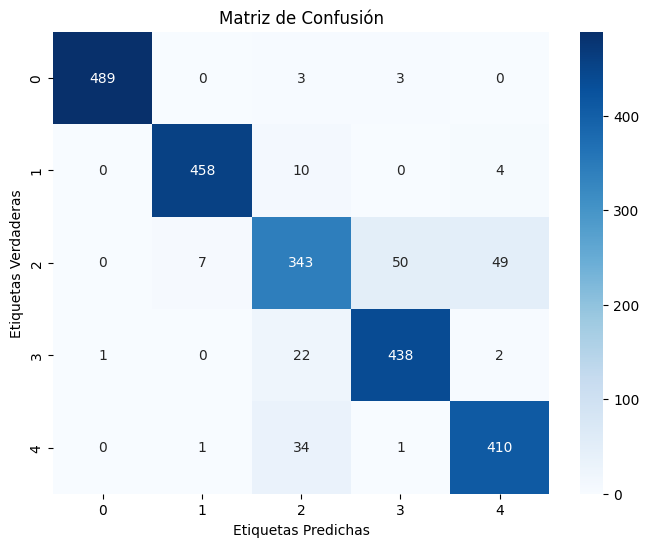

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_700_0.0001_0.1/resultados_700_0.0001_0.1.json
Procesando red con 700 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.9


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 700/700 [15:28<00:00,  1.33s/it]

El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_700_1e-05_0.1/funcion_de_perdida_700_1e-05.png


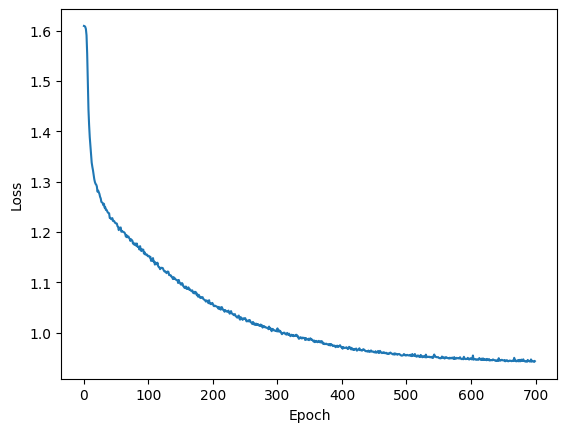

Test accuracy: 465.9161290322581
Accuracy: 0.8653763440860215
Precision: 0.8620843094515512
Recall: 0.8622173406910164
F1-score: 0.8620954743470095


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       495
           1       0.95      0.96      0.95       472
           2       0.70      0.70      0.70       449
           3       0.83      0.83      0.83       463
           4       0.86      0.84      0.85       446

    accuracy                           0.87      2325
   macro avg       0.86      0.86      0.86      2325
weighted avg       0.86      0.87      0.87      2325

                    0           1           2           3           4  \
precision    0.964356    0.947479    0.701559    0.832972    0.864055   
recall       0.983838    0.955508    0.701559    0.829374    0.840807   
f1-score     0.974000    0.951477    0.701559    0.831169    0.852273   
support    495.000000  472.000000  449.000000 

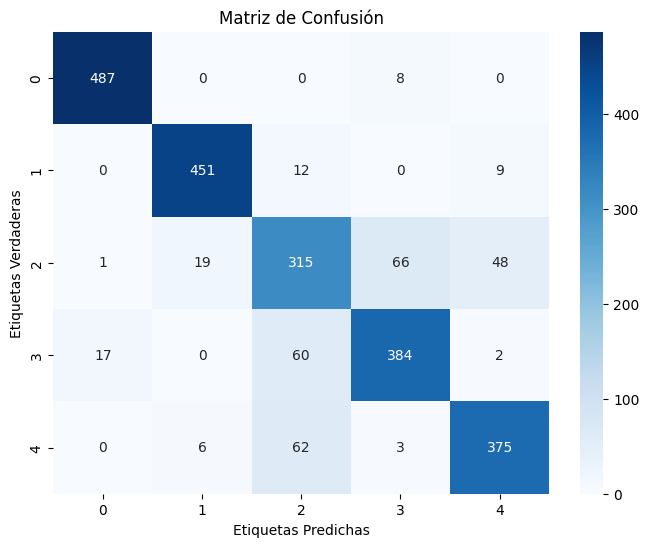

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_700_1e-05_0.1/resultados_700_1e-05_0.1.json
Procesando red con 1000 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.9


Procesando epocas: 100%|███████████████████████████████████████████████████████████| 1000/1000 [17:44<00:00,  1.06s/it]

El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_1000_0.0001_0.1/funcion_de_perdida_1000_0.0001.png


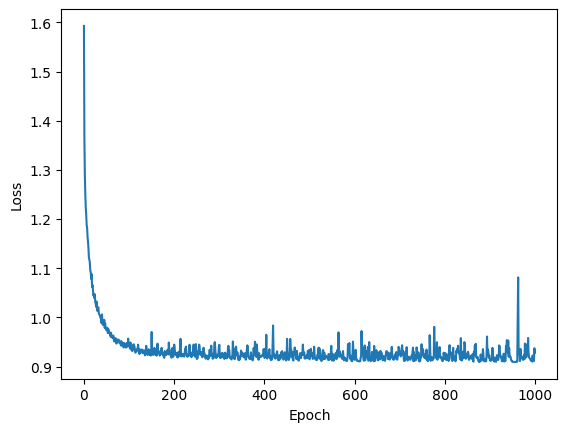

Test accuracy: 466.2430107526882
Accuracy: 0.8924731182795699
Precision: 0.8991202305443101
Recall: 0.8892725978789955
F1-score: 0.8895534577595298


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       495
           1       0.98      0.97      0.97       472
           2       0.77      0.76      0.77       449
           3       0.79      0.98      0.87       463
           4       0.97      0.76      0.85       446

    accuracy                           0.89      2325
   macro avg       0.90      0.89      0.89      2325
weighted avg       0.90      0.89      0.89      2325

                    0           1           2           3           4  \
precision    0.995876    0.976445    0.770270    0.787197    0.965812   
recall       0.975758    0.966102    0.761693    0.982721    0.760090   
f1-score     0.985714    0.971246    0.765957    0.874159    0.850690   
support    495.000000  472.000000  449.000000 

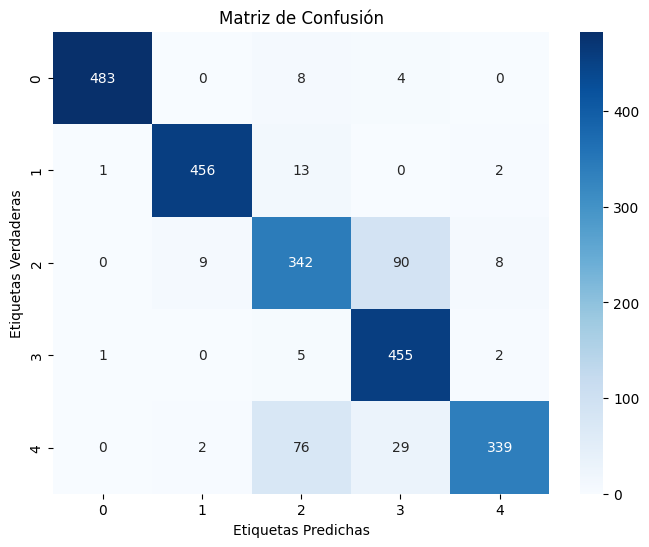

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_1000_0.0001_0.1/resultados_1000_0.0001_0.1.json
Procesando red con 1000 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.9


Procesando epocas: 100%|███████████████████████████████████████████████████████████| 1000/1000 [13:34<00:00,  1.23it/s]


El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\Roberta_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_1000_1e-05_0.1/funcion_de_perdida_1000_1e-05.png


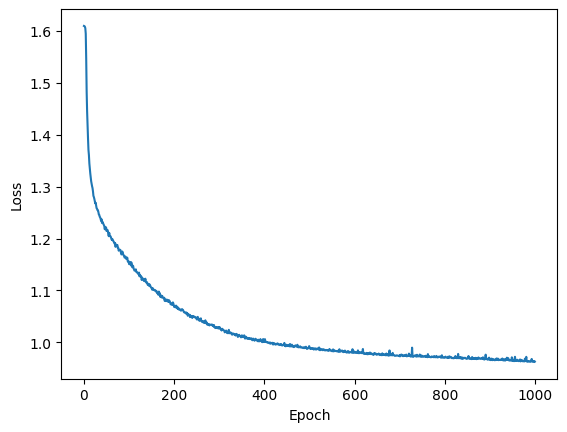

Test accuracy: 465.3643010752688
Accuracy: 0.8253763440860215
Precision: 0.8238489383973894
Recall: 0.8215512549829267
F1-score: 0.8216965652397015


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       495
           1       0.97      0.88      0.92       472
           2       0.67      0.62      0.64       449
           3       0.80      0.85      0.82       463
           4       0.71      0.78      0.74       446

    accuracy                           0.83      2325
   macro avg       0.82      0.82      0.82      2325
weighted avg       0.83      0.83      0.83      2325

                    0           1           2           3           4  \
precision    0.975709    0.965278    0.667464    0.800000    0.710794   
recall       0.973737    0.883475    0.621381    0.846652    0.782511   
f1-score     0.974722    0.922566    0.643599    0.822665    0.744931   
support    495.000000  472.000000  449.000000 

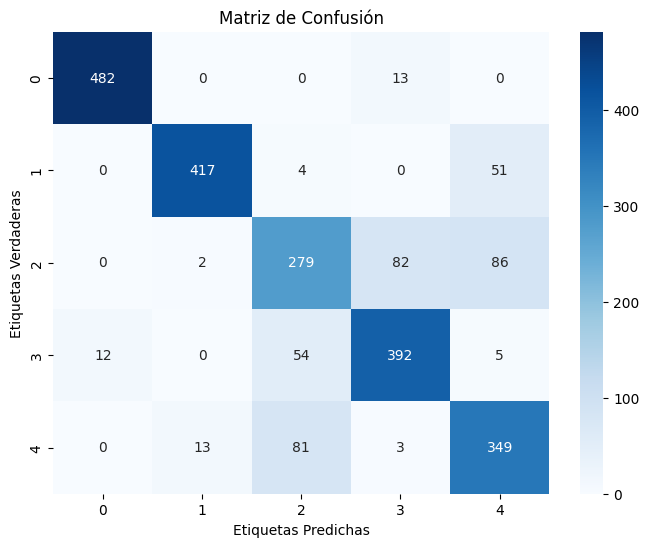

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/Roberta_embeddings/Neural_network_classification/RRN_1000_1e-05_0.1/resultados_1000_1e-05_0.1.json


In [13]:
epocas = [500,700,1000]
lr = [0.0001,0.00001]
test_label = [0.3,0.2,0.1]
#RNN_model(X, labels ,0.3,10,0.001)

for test in test_label:
    for epoca in epocas:
        for rang in lr:
                print(f"Procesando red con {epoca} epocas y {rang} de factor de aprendizaje y conjunto de entrenamiento {1-test}")
                RNN_model(X, labels ,test,epoca,rang)